# Kinematics, Dynamics, Visualization + Control

In [1]:
import numpy as np
from numpy import sin, cos
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp

from functools import partial

from IPython.display import clear_output

In [250]:
class Biped():
    def __init__(self, m1 = 7, m2 = 7, m3 = 17,
                l1 = 0.5, l2 = 0.5, l3 = 0.35, g = 9.81):
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.l1 = l1
        self.l2 = l2
        self.l3 = l3
        self.g = g
        self.control_parameters = np.array([457.5, 161, 77.05, 5, 10.4*np.pi/180])        
        
    def kin_hip(self, q, dq = None):
        if dq is None: dq = np.zeros(3)
        
        x_h = self.l1*sin(q[0])  
        z_h = self.l1*cos(q[0])  
        dx_h = self.l1*cos(q[0])*dq[0]  
        dz_h = -self.l1*sin(q[0])*dq[0]
        return x_h, z_h, dx_h, dz_h
    
    def kin_swf(self, q, dq = None):
        if dq is None: dq = np.zeros(3)
        
        x_swf = self.l1*sin(q[0]) - self.l2*sin(q[1])  
        z_swf = self.l1*cos(q[0]) - self.l2*cos(q[1])
        dx_swf = self.l1*cos(q[0])*dq[0] - self.l2*cos(q[1])*dq[1]  
        dz_swf = -self.l1*sin(q[0])*dq[0] + self.l2*sin(q[1])*dq[1]
        return x_swf, z_swf, dx_swf, dz_swf
    
    def eval_A_m(self, q_m):
        t2 = q_m[0]-q_m[1]
        t3 = cos(t2)
        t4 = self.l1**2
        t5 = self.m1*t4*0.25
        t6 = q_m[0] - q_m[2]
        t7 = cos(t6)
        t8 = self.l3**2
        m, m3 = self.m1, self.m3
        l1,l2,l3 = self.l1, self.l2, self.l3
        A_m = np.array([t5-l1*l2*m*t3-l1*l2*m3*t3-l1*l3*m3*t7*(1.0/2.0), 
                        t5,l1*l3*m3*t7*(-1.0/2.0),l2**2*m*(1.0/4.0),0.0,0.0,\
                        m3*t8*(-1.0/4.0)-l2*l3*m3*cos(q_m[1]-q_m[2])*(1.0/2.0),\
                        0.0,m3*t8*(-1.0/4.0)]).reshape(3,3).T
        return A_m
    
    def eval_A_p(self, q_p):
        q1_p = q_p[0]
        q2_p = q_p[1]
        q3_p = q_p[2]
        m, m3, l1, l2, l3 = self.m1, self.m3, self.l1, self.l2, self.l3
        
        t2 = l1**2;
        t3 = q1_p-q2_p;
        t4 = cos(t3);
        t5 = l1*l2*m*t4*(1.0/2.0);
        t6 = q1_p-q3_p;
        t7 = cos(t6);
        t8 = l2**2;
        t9 = l3**2;
        A_p = np.array([t5-m*t2*(5.0/4.0)-m3*t2-l1*l3*m3*t7*(1.0/2.0),t5,l1*l3*m3*t7*(-1.0/2.0),t5-m*t8*(1.0/4.0),
                       m*t8*(-1.0/4.0),0.0,m3*t9*(-1.0/4.0)-l1*l3*m3*t7*(1.0/2.0),0.0,m3*t9*(-1.0/4.0)]).reshape(3,3).T
        return A_p
    
    def eval_B(self):
        B = np.array([1.0,0.0,0.0, 1.0,-1.0,-1.0]).reshape(3,2)
        return B
    
    def eval_C(self, q, dq):
        q1, q2, q3 = q[0], q[1], q[2]
        dq1, dq2, dq3 = dq[0], dq[1], dq[2]

        m1, m2, m3, l1, l2, l3 =  self.m1, self.m2,  self.m3, self.l1, self.l2, self.l3

        t2 = q1-q2
        t3 = sin(t2)
        t4 = q1-q3
        t5 = sin(t4)
        C = np.array([0.0,dq1*l1*l2*m2*t3*(1.0/2.0),dq1*l1*l3*m3*t5*(-1.0/2.0),
                      dq2*l1*l2*m2*t3*(-1.0/2.0),0.0,0.0,dq3*l1*l3*m3*t5*(1.0/2.0),0.0,0.0]).reshape(3,3).T
        return C
    
    def eval_energy(self, q, dq):
        q1, q2, q3 = q[0], q[1], q[2]
        dq1, dq2, dq3 = dq[0], dq[1], dq[2]

        m1, m2, m3, l1, l2, l3, g =  self.m1, self.m2,  self.m3, self.l1, self.l2, self.l3, self.g

        T = (dq1**2*l1**2*m1)/8 + (dq1**2*l1**2*m2)/2 + (dq1**2*l1**2*m3)/2 + (dq2**2*l2**2*m2)/8 + (dq3**2*l3**2*m3)/8 - (dq1*dq2*l1*l2*m2*cos(q1 - q2))/2 + (dq1*dq3*l1*l3*m3*cos(q1 - q3))/2;
        V = g*m2*(l1*cos(q1) - (l2*cos(q2))/2) + g*m3*(l1*cos(q1) + (l3*cos(q3))/2) + (g*l1*m1*cos(q1))/2;
        return T, V
    
    def eval_G(self, q):
        q1, q2, q3 = q[0], q[1], q[2]
        m1, m2, m3, l1, l2, l3, g =  self.m1, self.m2,  self.m3, self.l1, self.l2, self.l3, self.g
        
        G = np.array([g*l1*sin(q1)*(m1+m2*2.0+m3*2.0)*(-1.0/2.0)
                      ,g*l2*m2*sin(q2)*(1.0/2.0),g*l3*m3*sin(q3)*(-1.0/2.0)])
        return G
    
    def eval_M(self, q):
        q1, q2, q3 = q[0], q[1], q[2]
        m1, m2, m3, l1, l2, l3, g =  self.m1, self.m2,  self.m3, self.l1, self.l2, self.l3, self.g

        t2 = q1-q2;
        t3 = cos(t2);
        t4 = q1-q3;
        t5 = cos(t4);
        t6 = l1*l3*m3*t5*(1.0/2.0);
        M = np.array([l1**2*(m1*(1.0/4.0)+m2+m3),l1*l2*m2*t3*(-1.0/2.0),
                      t6,l1*l2*m2*t3*(-1.0/2.0),l2**2*m2*(1.0/4.0),0.0,
                      t6,0.0,l3**2*m3*(1.0/4.0)]).reshape(3,3)
        return M
    
    def impact(self, q_m, dq_m):
        q_p = np.array([q_m[1], q_m[0], q_m[2]])
        A_m = self.eval_A_m(q_m);
        A_p = self.eval_A_p(q_p);
        dq_p = np.linalg.pinv(A_p).dot(A_m).dot(dq_m)
        return q_p, dq_p
    
    def control(self, t, q, dq, q0, dq0, step_number, parameters):
        kp1 = parameters[0];
        kp2 = parameters[1];
        kd1 = parameters[2];
        kd2 = parameters[3];
        alpha = parameters[4];

        y1 = q[2]-alpha;
        y1d = dq[2];
        y2 = -q[1]-q[0];
        y2d = -dq[1]-dq[0];

        u1 = kp1*y1 + kd1*y1d;

        u2 = kp2*y2 + kd2*y2d;

        u1 = max(min(u1, 30), -30) 
        u2 = max(min(u2, 30), -30) 
        u = np.array([u1, u2])
        return u
    
    def eqns(self, t, y, y0, step_number, parameters):    
        q = y[:3]
        dq = y[3:]
        q0 = y0[3:]
        dq0 = y0[3:]
        
        M = self.eval_M(q)
        C = self.eval_C(q, dq)
        G = self.eval_G(q)
        B = self.eval_B()

        u = self.control(t, q, dq, q0, dq0, step_number, parameters)

        n = 6
        dy = np.zeros(n)
        dy[:3] = y[3:];
        dy[3:] = np.linalg.inv(M).dot(-C.dot(dq) - G + B.dot(u));
        return dy
    
    def visualize(self, q, r0 = None):
        plt.figure(figsize=(10,10))
        if r0 is None: r0 = np.zeros(2)

        x0 = r0[0];
        z0 = r0[1];

        l1, l2, l3 = self.l1, self.l2, self.l3 
        q1, q2, q3 = q[0], q[1], q[2]

        x1 = (l1*sin(q1))/2 + x0;
        z1 = (l1*cos(q1))/2 + z0;
        x2 = l1*sin(q1) - (l2*sin(q2))/2 + x0;
        z2 = l1*cos(q1) - (l2*cos(q2))/2 + z0;
        x3 = l1*sin(q1) + (l3*sin(q3))/2 + x0;
        z3 = l1*cos(q1) + (l3*cos(q3))/2 + z0;

        x_h = l1*sin(q1) + x0;
        z_h = l1*cos(q1) + z0;

        x_t = l1*sin(q1) + l3*sin(q3) + x0;
        z_t = l1*cos(q1) + l3*cos(q3) + z0;

        x_swf = l1*sin(q1) - l2*sin(q2) + x0;
        z_swf = l1*cos(q1) - l2*cos(q2) + z0;

        lw = 5;
        # links
        plt.plot([x0, x_h], [z0, z_h], linewidth = lw); 
        plt.plot([x_h, x_t], [z_h, z_t], linewidth = lw); 
        plt.plot([x_h, x_swf], [z_h, z_swf], linewidth = lw);
        # plot a line for "ground"
        plt.plot([-1 + x_h, 1 + x_h], [0, 0], 'b');
        plt.axis('equal')
        plt.xlim([-1 + x_h, 1 + x_h]);
        plt.ylim([-0.8, 1.2]);
        # point masses
        mz = 15;
        plt.plot(x1, z1, '.', markersize = mz); 
        plt.plot(x2, z2, '.',  markersize = mz); 
        plt.plot(x3, z3, '.',  markersize = mz);
        plt.show()
        
        
    def animate(self, sln):
        skip = 10;
        tic = time.time();
        
        num_steps = len(sln['T'])
        r0 = np.zeros(2)
        for j in range(num_steps):
            Y = sln['Y'][j]
            N = len(Y)
            for i in range(0, N, skip):
                q = Y[i, :3];
                #time.sleep(0.002);
                self.visualize(q, r0);
                clear_output(wait=True)
            x0, _,_,_ = self.kin_swf(q);
            r0 = r0 + np.array([x0, 0]);

        toc = time.time()
        
        real_time_factor = sln['T'][-1][-1] / (toc-tic)
        print('Real time factor:{}'.format(real_time_factor))
        return real_time_factor
    
    def solve_eqns(self, q0, dq0, num_steps, parameters):
        
        #options = odeset('RelTol',1e-5, 'Events', @event_func);
        h = 0.001; # time step
        tmax = 2; # max time that we allow for a single step
        tspan = np.arange(0, tmax, h)
        y0 = np.concatenate([q0, dq0])
        t0 = 0

        sln = {'T' : [], 'Y' : [], 'TE' : [], 'YE' : []}
        
        for i in range(num_steps):
            eqns_std = partial(biped.eqns, y0 = y0,step_number = num_steps, parameters = parameters )
            sol = solve_ivp(eqns_std, (t0, t0+tmax),  y0, t_eval = tspan, events = event_func, rtol = 1e-5)            
            sln['T'] += [sol.t]
            sln['Y'] += [sol.y.T]
            sln['TE'] += [sol.t_events]

            if np.abs(sol.t[-1]- tmax) < 1e-4:
                break

            if len(sol.t_events) == 0:
                break

            # Impact map
            q_m = sol.y.T[-1,:3]
            dq_m = sol.y.T[-1,3:]
            q_p, dq_p = self.impact(q_m, dq_m);

            y0 = np.concatenate([q_p, dq_p])
            t0 = sol.t[-1]
            tspan = np.arange(t0, t0+tmax, h)
        return sln
    
    def analyse(self, sln, to_plot = True):
        x_hs = [];
        dx_hs_mean = [];
        dx_hs = [];

        z_hs = [];
        dz_hs = [];

        qs = [];
        dqs = [];
        us = [];

        t_hs = [];

        fs = [];
        ds = [];
        effort = 0;
        cot = 0;
        
        for i in range(len(sln['Y'])):
            Y = sln['Y'][i]
            T = sln['T'][i]
            t_hs += [T];
            dt = T[-1] - T[0]
            f = 1.0/dt;
            fs += [f]

            for j in range(len(Y)):
                y = Y[j]
                x_h, z_h, dx_h, dz_h =  self.kin_hip(y[:3], y[3:])
                x_hs += [x_h]
                dx_hs += [dx_h]
                z_hs += [z_h]
                dz_hs += [dz_h]

                qs += [y[:3]]
                dqs += [y[3:]]
                u = self.control(0, y[:3], y[3:],0,0,0,self.control_parameters);
                us += [u]

            y = Y[0]
            x_h0, z_h0, dx_h, dz_h =  self.kin_hip(y[:3], y[3:])
            y = Y[-1]
            x_hT, z_hT, dx_h, dz_h =  self.kin_hip(y[:3], y[3:])
            d = x_hT - x_h0;
            ds += [d]

            dx_hs_mean += [d/dt]

        results = dict();
        results['x_h'] = np.array(x_hs);
        results['dx_h'] = np.array(dx_hs);
        results['z_h'] = np.array(z_hs);
        results['dz_h'] = np.array(dz_hs);
        results['t_h'] = np.concatenate(t_hs);
        
        results['qs'] = np.array(qs)
        results['dqs'] = np.array(dqs)
        results['us'] = np.array(us)

        results['fs'] = np.array(fs)
        results['ds'] = np.array(ds)
        
        T = results['t_h'][-1]
        Umax = 30;
        #results.effort = sum(results.us.^2, 'all')/(2*T*Umax);
        #results.cot = results.effort/sum(results.ds);

        results['dx_hs_mean'] = np.array(dx_hs_mean)
        results['mean_velocity'] = np.sum(results['ds'])/T
        
        if to_plot:
            plt.figure()
            plt.plot(results['t_h'], (results['x_h']))
            plt.figure()
            plt.plot(results['t_h'], (results['z_h']))
            for j in range(3):
                plt.figure()
                plt.plot(results['qs'][:,j], results['dqs'][:,j])
            
            plt.figure()
            plt.plot(results['t_h'], (results['dx_h']))
            
            plt.figure()
            plt.plot((results['dx_hs_mean']))

            plt.figure()
            plt.plot((results['fs'][1:]), '-o')
            
            plt.figure()
            plt.plot((results['ds'][0:]), '-o')

            for j in range(2):
                plt.figure()
                plt.plot(results['t_h'], (results['us'][:,j]))
            
            
        return results

In [251]:
def event_func(t, y):
    q = y[:3]
    dq = y[3:]

    _, z_swf, _,_ = biped.kin_swf(q, dq)
    value = z_swf + 0.01 * cos(q[0]) + 0.0001
    return value
event_func.terminal = 1;
event_func.direction = -1;

In [252]:
biped = Biped()
q0 = np.array([np.pi/9, -np.pi/9, 0.])
dq0 = np.array([0.,0.,8.])

In [253]:
np.set_printoptions(precision=4, suppress=True)

#### Test

In [254]:
sln = biped.solve_eqns(q0, dq0, 10, biped.control_parameters);

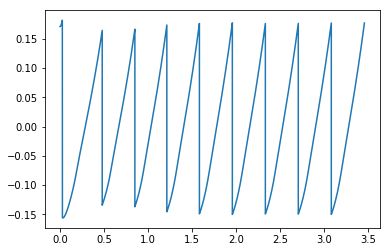

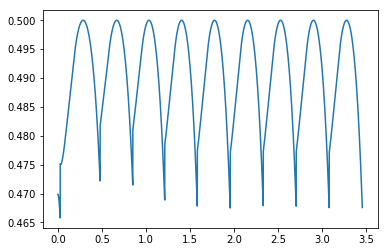

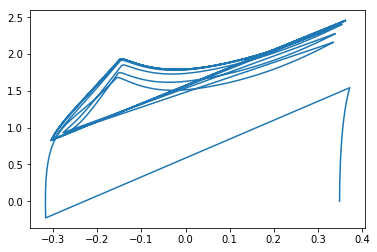

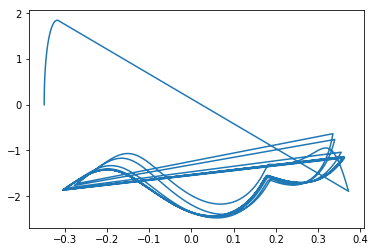

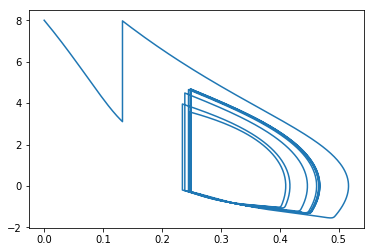

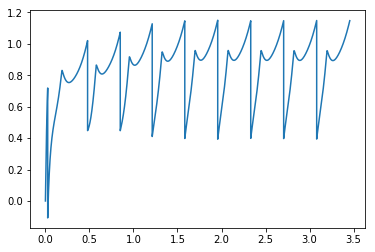

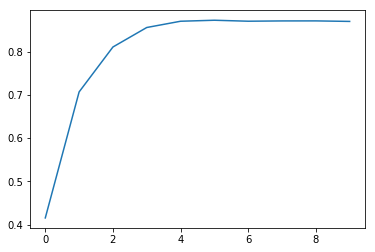

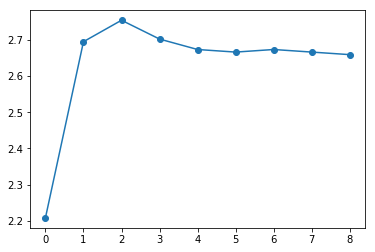

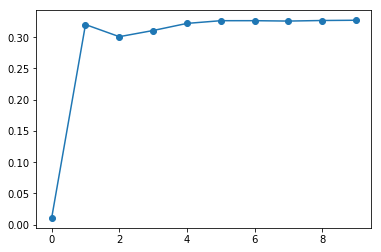

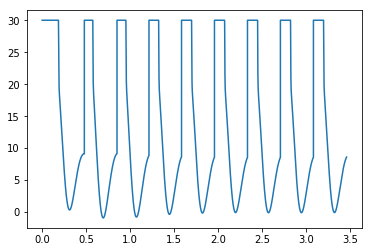

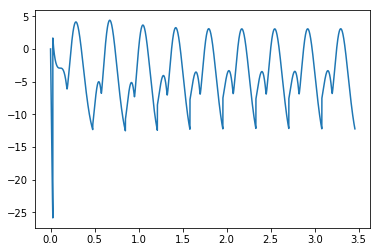

In [255]:
results = biped.analyse(sln)